# Reachability Analysis for Split Computing Neural Networks

## 1. Import Packages

In [4]:
begin
	import Pkg
	Pkg.activate("..")
	Pkg.instantiate()
	
    push!(LOAD_PATH, "$(@__DIR__)/../src")
    
    using Plots
    using NoisyReach
    using Distributions
    using Experiment
    using QuadGK
    using ControlSystemsBase
    using LinearAlgebra
    using ReachabilityAnalysis
end

  Activating project at `~/Downloads/sc/NoisyReach.jl`


## 2. Validation for Integral function

In [2]:
#const Ts = 0.01
#const Dc = 0.005 # 
#sys = benchmarks[:F1]

In [3]:
#sys_aug_ = let
#    ϕ = ℯ^(Ts * sys.A)
#    Γ₁ = matrix_integral(sys.A, sys.B, Dc, Ts)
#    Γ₀ = matrix_integral(sys.A, sys.B, 0.0, Ts - Dc)
#    ϕ_aug = [ϕ Γ₁; 0 0 0]
#    Γ_aug = [Γ₀; I]
#    C_aug = [sys.C 0]
#    ss(ϕ_aug, Γ_aug, C_aug, sys.D, Ts)
#end

In [4]:
#sys_aug = c2d(sys, Ts) * delay(Dc, Ts)
#sys_aug = c2d(sys, Ts) * thiran(Dc, Ts)

## 3. Physical System and Neural Networks Uncertainty Setup

In [5]:
sys = benchmarks[:F1]
const period = 0.02
const Dc1 =    0.005
const Dc2 =    period

0.02

In [6]:
sys_ideal = c2d(sys, period)
K_ideal = lqr(ControlSystemsBase.Discrete, sys_ideal.A, sys_ideal.B, I, I)

1×2 Matrix{Float64}:
 0.777044  1.05686

In [7]:
sys_aug = let
    ϕ = ℯ^(period * sys.A)
    Γ2 = matrix_integral(sys.A, sys.B, 0.0, period - Dc2)
    Γ1 = matrix_integral(sys.A, sys.B, 0.0, Dc2 - Dc1)
    Γ3 = matrix_integral(sys.A, sys.B, period - Dc2, period - Dc2+Dc1)
    ϕ_aug = [ϕ Γ3; 0 0 0]
    Γ_aug = [Γ1 Γ2; 0 I]
    C_aug = [sys.C 0]
    D_aug = [sys.D 0]
    ss(ϕ_aug, Γ_aug, C_aug, D_aug, period)
end
K = lqr(ControlSystemsBase.Discrete, sys_aug.A, sys_aug.B, I, I)

2×3 Matrix{Float64}:
 0.809378   1.17075   0.106169
 0.0707289  0.135018  0.0124974

In [8]:
σ1 = 0.3
σ2 = 0.2
μ = 0.
H = 10
x0 = 1.
u1_0 = 0.
u2_0 = 0.
u0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u2_0] # [X0; x0; ...; u2_0]
x0 = fill(x0, size(sys.A, 1))

2-element Vector{Float64}:
 1.0
 1.0

## 4. Calculate and Plot Reachable Trajectories

In [9]:
all_trajectories_z = []
all_trajectories_u = []
for i in 1:10000
    z, u = evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0, σ1, σ2, μ)
    push!(all_trajectories_z, z)
    push!(all_trajectories_u, u)
end
z_ideal, u_ideal = ideal_evolve(sys_ideal.A, sys_ideal.B, K_ideal, H, x0, u0)

([[1.0, 1.0], [1.13, 1.0], [1.309515718837338, 1.7617802898052037], [1.6122354116671223, 2.8954457537299385], [2.0990119492507007, 4.5934240552481915], [2.8621281948210733, 7.146825876603693], [4.041419731203601, 10.996120836973658], [5.848676622359113, 16.807831334649606], [8.604574840500852, 25.590602790607925], [12.79457040489092, 38.87086743077775], [19.15349221360622, 58.95869885714997]], [[0.0], [1.9349219361052175], [2.8795102783688273], [4.312864885856363], [6.485640626242975], [9.777209199339712], [14.761744664096911], [22.30823949813413], [33.73187218603135], [51.02309182298545], [77.1943220945282]])

In [10]:
const xlim = 60
const ylim = 250
Plots.scalefontsizes(1.8)

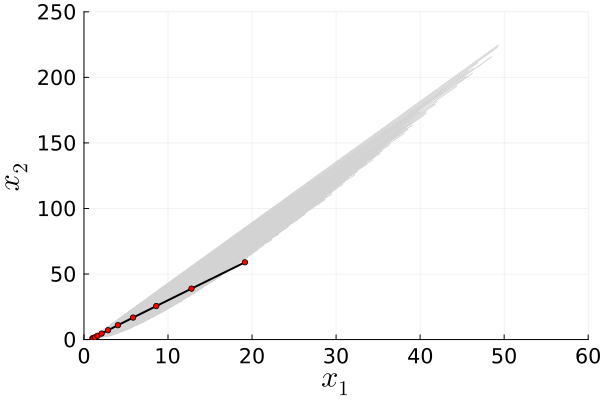

"/home/pgan/Downloads/sc/NoisyReach.jl/experiments/NN1.svg"

In [11]:
traj_plot = plot(xlabel="\$x_1\$", ylabel="\$x_2\$")#, title="x Trajectories")
for trajectory in all_trajectories_z
    x_z = [point[1] for point in trajectory]
    y_z = [point[2] for point in trajectory]
    
    plot!(x_z, y_z, xlim=(0, xlim), ylim=(0, ylim), label="", linecolor=:lightgray, linewidth=1)#, marker=:circle, markercolor=:yellow, markersize=2)
end
x_z_ideal = [point[1] for point in z_ideal]
y_z_ideal = [point[2] for point in z_ideal]
plot!(x_z_ideal, y_z_ideal, xlim=(0, xlim), ylim=(0, ylim), label="", linecolor=:black, linewidth=2, marker=:circle, markercolor=:red, markersize=3)
display(traj_plot)
savefig(traj_plot, "NN1.svg")

In [12]:
#traj_plot = plot(xlabel="\$u\$", ylabel="\$t\$")#, title="u Trajectories")
#for trajectory in all_trajectories_u
#    x_u = [point for point in trajectory]
#    y_u = [i for i in 1:length(trajectory)]
#    
#    plot!(x_u, y_u, xlim=(0, xlim), ylim=(0, ylim), label="", linecolor=:lightgray, linewidth=1)#, marker=:circle, markercolor=:yellow, markersize=2)
#end
#x_u_ideal = [point for point in u_ideal]
#y_u_ideal = [i for i in 1:length(u_ideal)]
#plot!(x_u_ideal, y_u_ideal, xlim=(0, xlim), ylim=(0, ylim), label="", linecolor=:black, linewidth=2, marker=:circle, markercolor=:red, markersize=3)
#display(traj_plot)
#savefig(traj_plot, "NN1_u.svg")

In [13]:
maximum(x -> maximum(_x -> _x[1], x), all_trajectories_z)

49.31644800912989

In [14]:
maximum(x -> maximum(_x -> _x[2], x), all_trajectories_z)

224.6344616601019

In [15]:
maximum(x -> x[1], z_ideal)

19.15349221360622

In [16]:
maximum(x -> x[2], z_ideal)

58.95869885714997

In [20]:
maximum(x -> maximum(_x -> (abs(_x[1]),abs(_x[2])), x), all_trajectories_u)

326.029039914954

In [18]:
maximum(x -> x[1], u_ideal)

77.1943220945282